# Summary of the TESS phase curve modelling results

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
import xarray as xa
import pandas as pd
from corner import corner
from pytransit.lpf.tesslpf import downsample_time
from src.tesslpf import K1TESSLPF

In [26]:
%run core.py

In [27]:
def read_mcmc(filename):
    with xa.load_dataset(filename) as ds:
        chain = ds['mcmc_samples'].data.reshape([-1, ds.parameter.size])
        df = pd.DataFrame(chain, columns=ds.parameter)
        df['k'] = sqrt(df.k2)
        return df

In [28]:
lpf = K1TESSLPF('KELT-1b-TESS', 'data', tic, zero_epoch.n, period.n, trdur=0.2, bldur=2)

TypeError: __init__() got an unexpected keyword argument 'trdur'

In [29]:
lpf = K1TESSLPF('')

In [30]:
dfa = read_mcmc('KELT-1b-TESS-a-unconstrained.nc')
dfb = read_mcmc('KELT-1b-TESS-b-emission-only.nc')
dfc = read_mcmc('KELT-1b-TESS-c-high-albedo.nc')

The two cases, *a* and *b*, differ only in the prior set on the geometric albedo. The case *a* does not constrain the geometric albedo while the case *b* forces it to (practially) zero.

## Basic parameters

The zero epoch, orbital period, stellar density, impact parameter, and radius ratio should all be not affected by the geometric albedo prior. Let's begin by plotting the three of these to make sure this is the case.

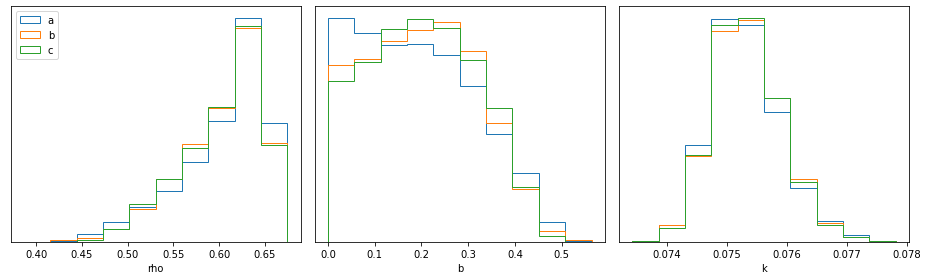

In [12]:
fig, axs = subplots(1, 3, figsize=(13,4))
for i, p in enumerate(('rho', 'b', 'k')):
    xmin = min(dfa[p].min(), dfb[p].min())
    xmax = max(dfa[p].max(), dfb[p].max())
    axs[i].hist(dfa[p], range=(xmin, xmax), histtype='step', label='a', density=True)
    axs[i].hist(dfb[p], range=(xmin, xmax), histtype='step', label='b', density=True)
    axs[i].hist(dfc[p], range=(xmin, xmax), histtype='step', label='c', density=True)
    setp(axs[i], xlabel=p, yticks=[])
axs[0].legend(loc='upper left')
fig.tight_layout()

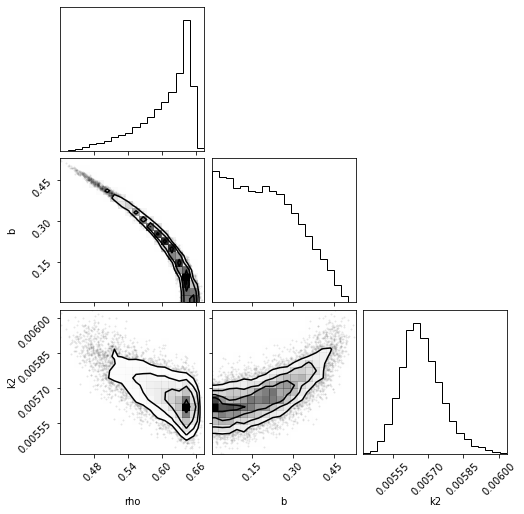

In [13]:
corner(dfa.iloc[:,[2,3,6]], labels=dfa.columns[[2,3,6]]);

## The phase curve parameters

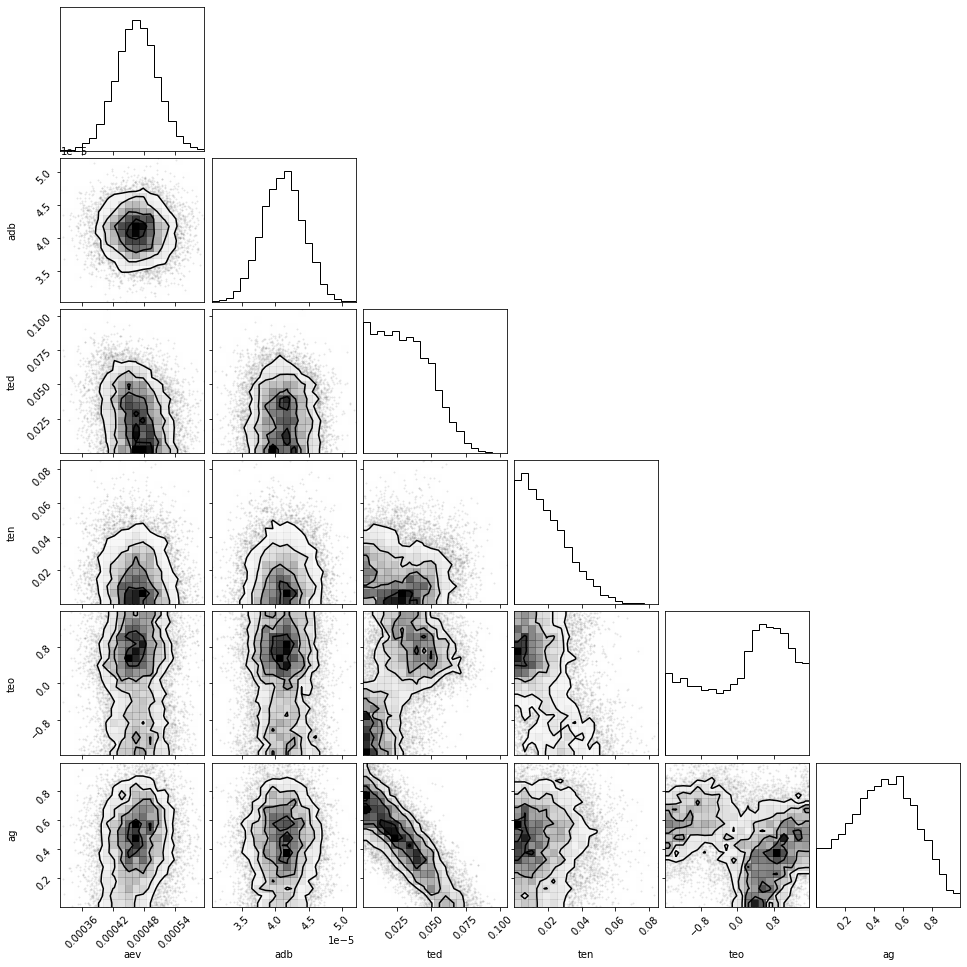

In [14]:
corner(dfa.iloc[:,7:13], labels=dfa.columns[7:13]);

In [19]:
pv = dfb.median()

(0.9994, 1.0002)

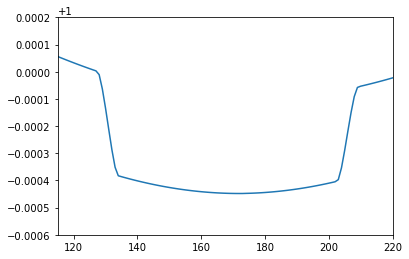

In [39]:
plot(lpf.transit_model(pv))
xlim(115,220)
ylim(0.9994, 1.0002)

In [40]:
dfb.ted.std()

0.011273658830406479

In [43]:
dfb.ted.median()

0.06411518980764855

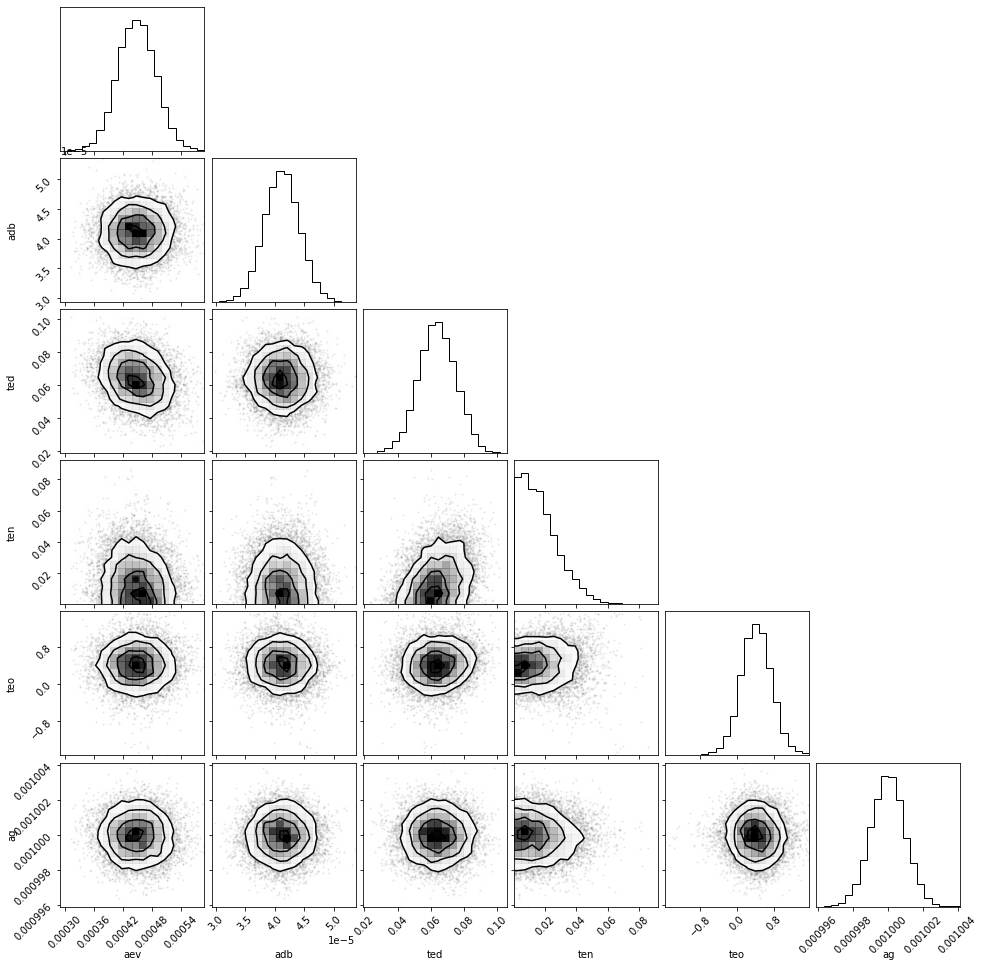

In [15]:
corner(dfb.iloc[:,7:13], labels=dfb.columns[7:13]);

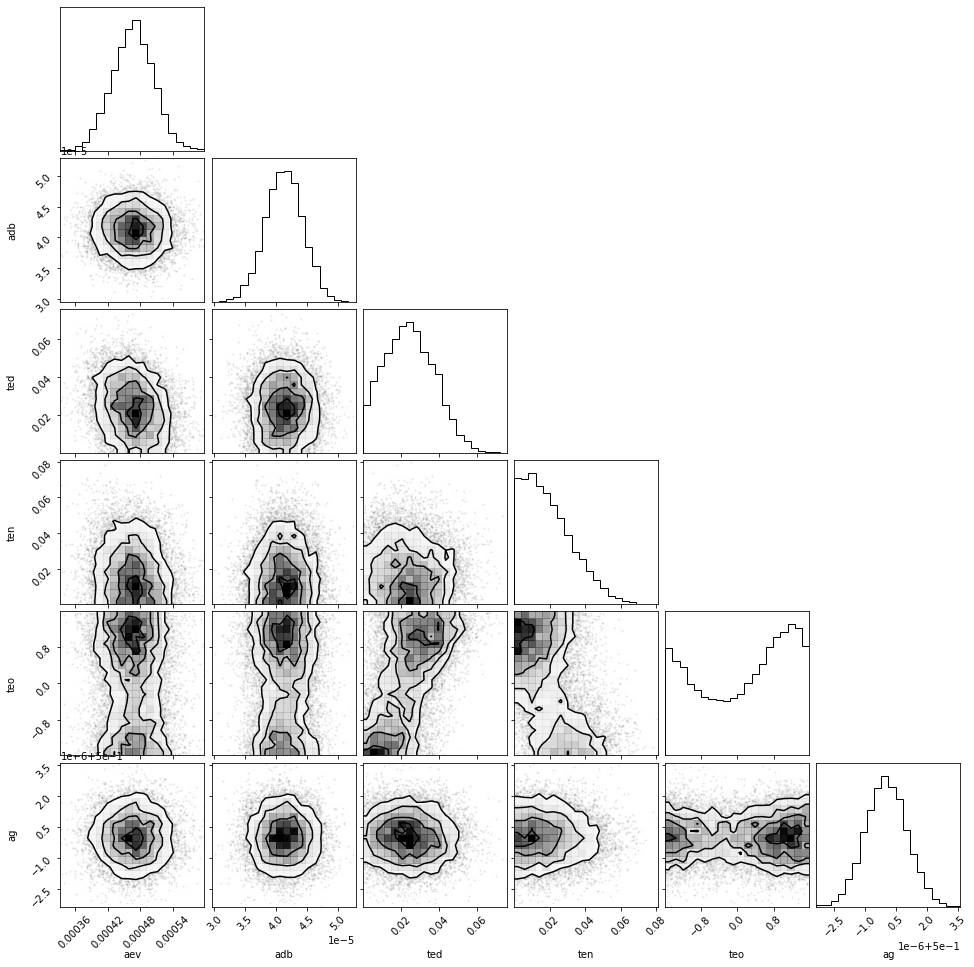

In [16]:
corner(dfc.iloc[:,7:13], labels=dfc.columns[7:13]);

## Rest of the parameters

Rest of the model parameters, such as the limb darkening coefficients or GP hyperparameters should also be independent of the prior set on the geometric albedo.

<AxesSubplot:>

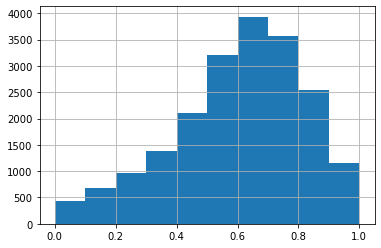

In [112]:
dfa.ag.hist()

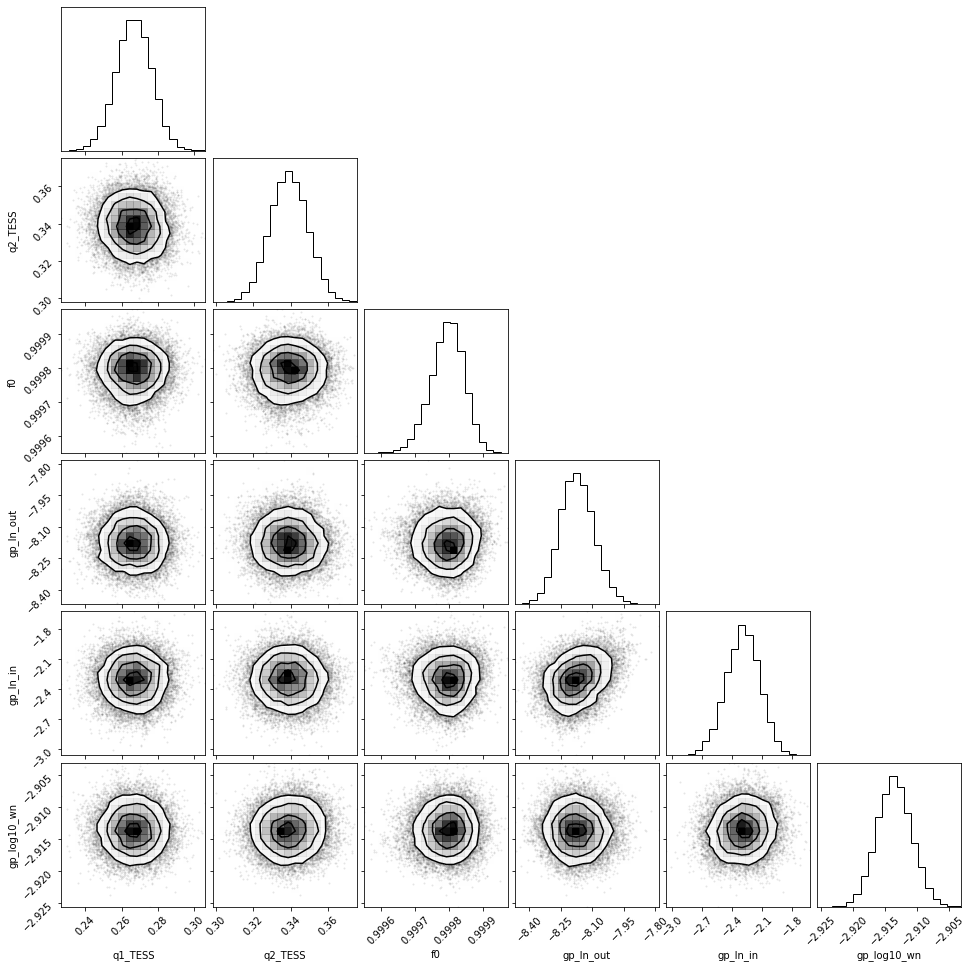

In [104]:
corner(dfa.iloc[:,13:19], labels=dfa.columns[13:19]);

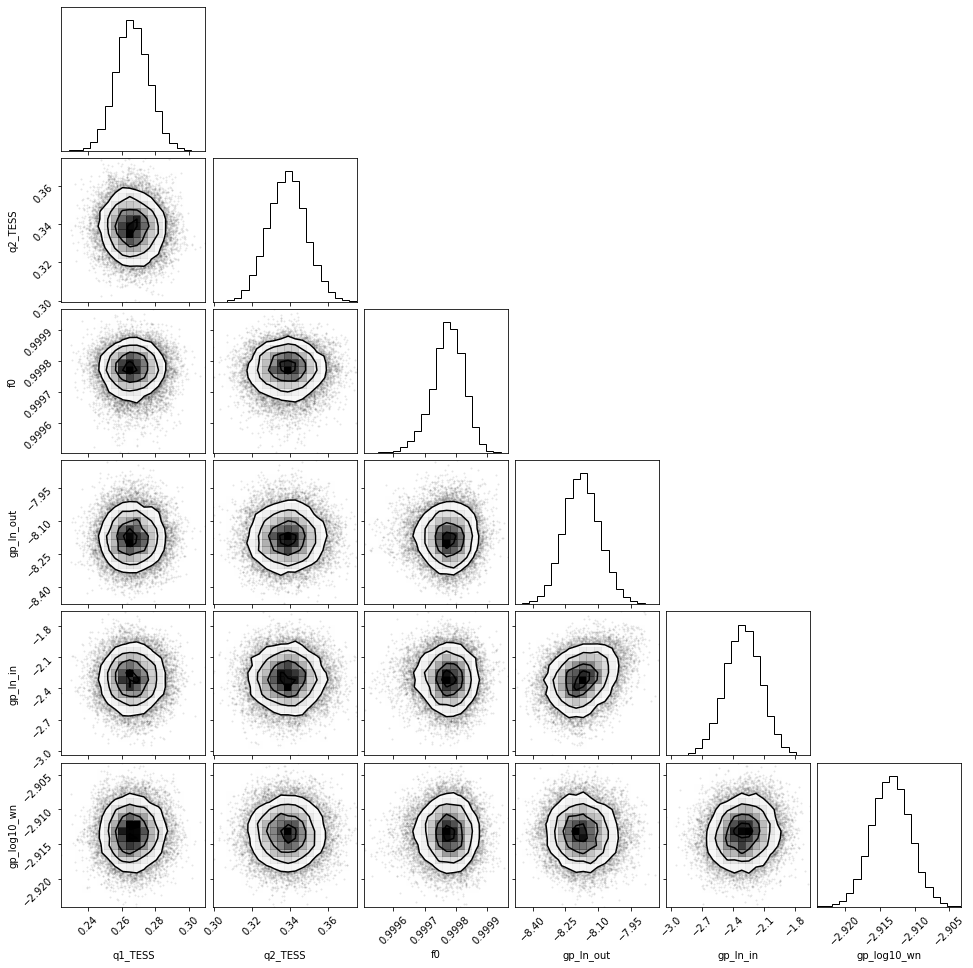

In [105]:
corner(dfb.iloc[:,13:19], labels=dfb.columns[13:19]);

<AxesSubplot:>

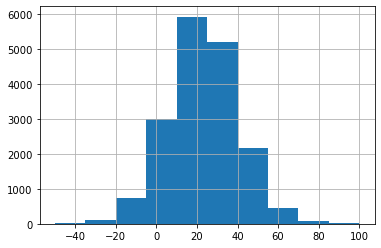

In [30]:
degrees(df.teo).hist(range=(-50,100))

<AxesSubplot:>

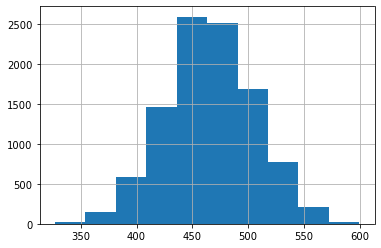

In [542]:
(1e6*df.aev).hist()

<AxesSubplot:>

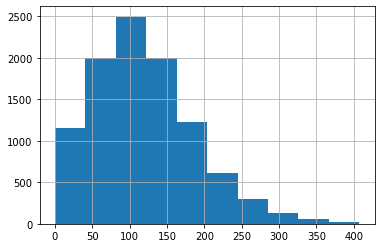

In [543]:
(1e6*df.adb).hist()

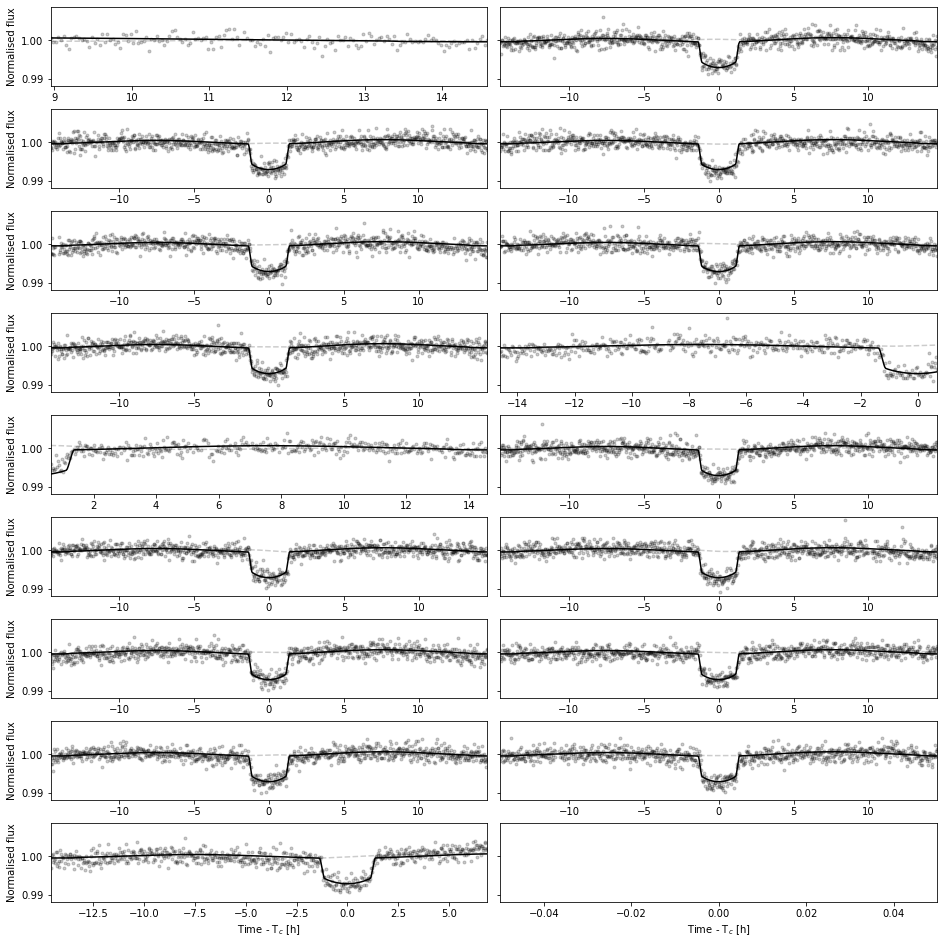

In [266]:
lpf.plot_individual_transits(figsize=(13,13));

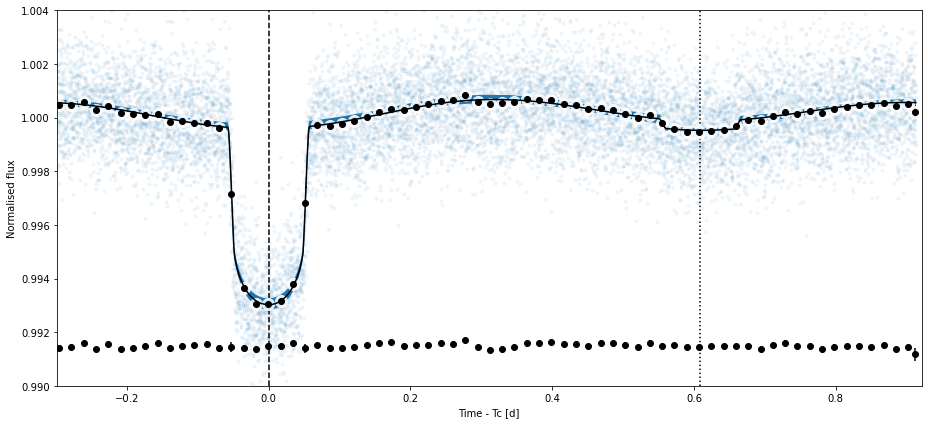

In [106]:
def plot_folded_transit(self, pvp, method='de', figsize=(13, 6), ylim=(0.9975, 1.002), xlim=None, binwidth=8,
                            remove_baseline: bool = False, offset: float = 0.5):
    
    pvp = permutation(pvp)[:500]
    pv = median(pvp, 0)
    
    tc, p = pv[[0, 1]]
    t0, p, a, inc, ecc, omega, area_ratio, k, ldc, aev, adb, dte, nte, ote, ab = self.map_pv(pvp)
    
    mp, mtc = median(p), median(tc)
    
    phase = mp * fold(self.timea, mp, mtc, offset)
    binwidth = binwidth / 24 / 60
    sids = argsort(phase)

    tm = self.transit_model(pvp)

    if remove_baseline:
        #gp = self._lnlikelihood_models[0]
        #bl = squeeze(gp.predict_baseline(pv))
        bl = median(self.baseline(pvp), 0)
    else:
        bl = ones_like(self.ofluxa)

    bp, bfo, beo = downsample_time(phase[sids], (self.ofluxa / bl)[sids], binwidth)
    _, bfm, _ = downsample_time(phase[sids], median(tm, 0)[sids], binwidth)

    fig, ax = subplots(figsize=figsize)
    ax.plot(phase - offset * mp, self.ofluxa / bl, '.', alpha=0.05)
    ax.errorbar(bp - offset * mp, bfo, beo, ms=12, fmt='wo', alpha=0.85)
    ax.errorbar(bp - offset * mp, bfo, beo, fmt='ko')
    ax.errorbar(bp - offset * mp, bfo-bfm + 0.9915, beo, fmt='ko')
    ax.plot(phase[sids] - offset * mp, median(tm[:,sids], 0), 'k', alpha=1, zorder=10)
    ax.fill_between(phase[sids]- offset * mp, *percentile(tm[:,sids], [1,99], axis=0))
    
    ax.axvline(0.0, c='k', ls="--")
    ax.axvline(0.5*mp, c='k', ls=":")
    xlim = xlim if xlim is not None else 1.01 * (bp[isfinite(bp)][[0, -1]] - offset * mp)
    setp(ax, ylim=ylim, xlim=xlim, xlabel='Time - Tc [d]', ylabel='Normalised flux')
    fig.tight_layout()
    return fig

plot_folded_transit(lpf, df.values, ylim=(0.99, 1.004), binwidth=25, remove_baseline=True, offset=0.25);